In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting as niplt
from neurosynth.base.dataset import Dataset
from base.tools import convert_nib
from scipy import interp
import glob

from base.classifiers import OnevsallClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import roc_auc_score, roc_curve

from nilearn.image import resample_img

import pandas as pd

:0: FutureWarning: IPython widgets are experimental and may change in the future.


### n-topics vs n-regions

In [6]:
sns.set_context('talk')

In [22]:
all_results = []
for classifier in glob.glob('../results/classification/*mc*/classifier_nd.pkl'):
    classifier = OnevsallClassifier.load(classifier)
    clf_name = str(classifier.classifier.__class__).split('.')[-1].split("'")[0]
    roc_auc = classifier.class_score.mean()
    n_topics = classifier.feature_importances.shape[1]
    n_regions = classifier.feature_importances.shape[0]
    sensitivity = np.array([recall_score(*fold) for region in classifier.predictions for fold in region]).mean()
    specificity = np.array([specificity_score(*fold) for region in classifier.predictions for fold in region]).mean()
    all_results.append([clf_name, n_topics, n_regions, roc_auc, sensitivity, specificity])
    
all_results  = pd.DataFrame(all_results, columns=['clf', 'n_topics', 'n_regions', 'roc_auc', 'sensitivity', 'specificity'])

In [28]:
all_results = all_results[all_results.n_regions < 120]

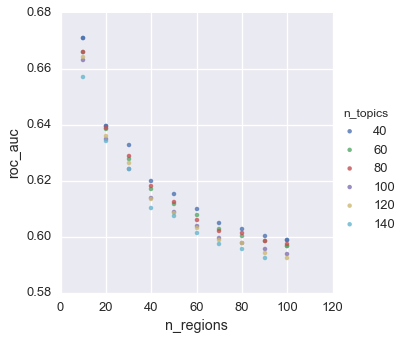

In [29]:
sns.lmplot('n_regions', 'roc_auc', all_results, hue ='n_topics', fit_reg=False)

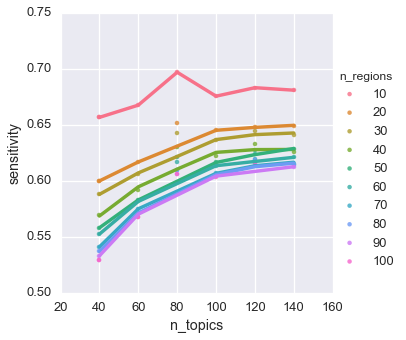

In [39]:
sns.lmplot('n_topics', 'sensitivity', all_results,  hue='n_regions', lowess=True)

/Users/aleph4/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


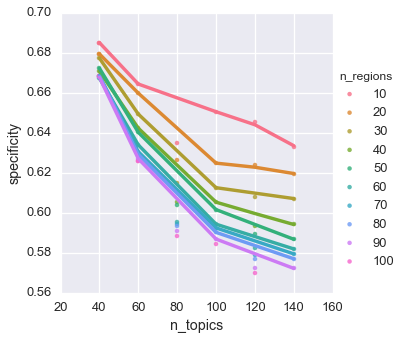

In [38]:
sns.lmplot('n_topics', 'specificity',  all_results, hue='n_regions', lowess=True)

In [7]:
def plot_roc_auc(fpr, tpr, roc_auc=None):
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    if roc_auc is None:
        plt.plot(fpr, tpr, 'k--', lw=2)
    else:
        plt.plot(fpr, tpr, 'k--',
             label='ROC (area = %0.2f)' % roc_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

## For individual features

In [12]:
dataset = Dataset.load('../data/0.6/datasets/db_v6_topics-100.pkl')

In [13]:
clf = OnevsallClassifier.load('../results/classification/neurosynth_mc_100_GNB_t0.05_all_topics_100/classifier_nd.pkl')

In [ ]:
clf.dataset = dataset
clf.load_data(None, None)

Loading data from neurosynth...
[##########] 100%

In [ ]:
clf.data[0][0].shape

In [10]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
def specificity_score(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[0, 0] * 1.0 / confusion_matrix(y_true, y_pred)[:, 0].sum()
    
def mean_roc_report(folds):
    return{'roc_auc': np.array([roc_auc_score(*fold) for fold in folds]).mean(),
           'sensitivity' : np.array([recall_score(*fold) for fold in folds]).mean(),
           'specificity' : np.array([specificity_score(*fold) for fold in folds]).mean()}

In [11]:
from neurosynth.analysis import classify

In [12]:
dacc = 19 -1
vmpfc = 21 -1
mid_dlpfc = 74 -1
sma = 11 - 1

In [13]:
fis = clf.feature_importances.data

In [14]:
## Max feature
max_f = np.where(fis[dacc, :] == np.max(fis[dacc, :]))[0]
clf.feature_names[max_f]

'2_pain_ocd_painful'

In [15]:
mean_roc_report(clf.predictions[dacc])

{'roc_auc': 0.558829175433184,
 'sensitivity': 0.50672645739910316,
 'specificity': 0.84612030772570146}

In [16]:
X, y = clf.data[dacc]

In [17]:
X_max = X[:, max_f]
output_max = classify.classify(
        X_max, y, classifier=clf.classifier, cross_val='4-Fold', scoring = roc_auc_score)

In [18]:
pd.DataFrame([mean_roc_report(output_max['predictions']), mean_roc_report(output_max['predictions'])])

,roc_auc,sensitivity,specificity
0,0.52835,0.077915,0.824945
1,0.52835,0.077915,0.824945


### For every region at 100 topics

In [19]:
from base import tools

In [20]:
## Overall sensitivity / specificity
all_specificity = []
for i, (predictions) in enumerate(clf.predictions):
    report = mean_roc_report(predictions)
    report['region'] = i
    all_specificity.append(report)
all_specificity = pd.DataFrame(all_specificity)
all_specificity.region += 1

In [21]:
base_rates = tools.region_vox_baserates(dataset, convert_nib(nib.load(clf.mask_img)))

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


In [22]:
base_rates = base_rates.groupby('region').mean().reset_index()

In [23]:
n_voxels = tools.region_n_vox(dataset, convert_nib(nib.load(clf.mask_img)))

In [24]:
n_voxels

,region,n_vox
0,1,1363
1,2,3361
2,3,1835
3,4,4644
4,5,1332
5,6,1600
6,7,495
7,8,1887
8,9,4140
9,10,1618


In [25]:
all_specificity = pd.merge(pd.merge(all_specificity, base_rates), n_voxels)

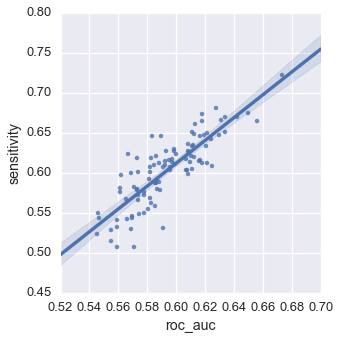

In [26]:
sns.lmplot('roc_auc', 'sensitivity', all_specificity)

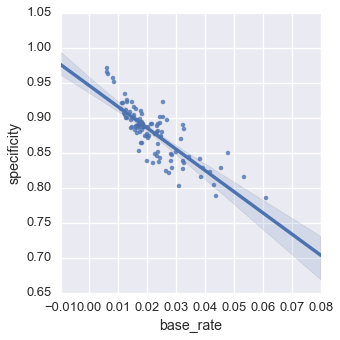

In [27]:
sns.lmplot('base_rate', 'specificity', all_specificity)

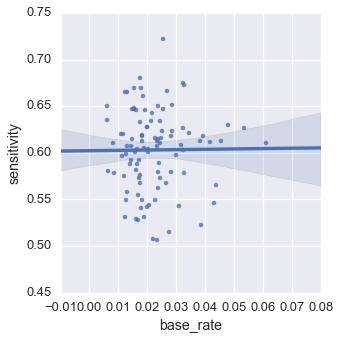

In [28]:
sns.lmplot('base_rate', 'sensitivity', all_specificity)

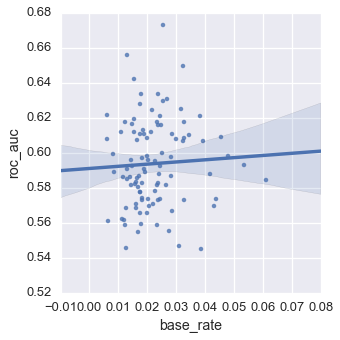

In [29]:
sns.lmplot('base_rate', 'roc_auc', all_specificity)

### For every region as number of topics in model increases

In [30]:
def classification_by_topics(args):
    (data, fis, classifier), reg = args
    
    fis_reg = fis[reg, :]
    X, y = data[reg]
    results = []
    for n_topics in range(1, fis_reg.shape[0]):
        ix =  np.argpartition(fis_reg, -n_topics)[-n_topics:]
        X_i = X[:, ix]
        output_i = classify.classify(
            X_i, y, classifier=classifier, cross_val='4-Fold', scoring = roc_auc_score)
        report = mean_roc_report(output_i['predictions'])
        report['region'] = reg
        report['n_topics'] = n_topics
        results.append(report)
    return results

In [31]:
import itertools

In [32]:
processes = 7
if processes > 1:
    from multiprocessing import Pool
    pool = Pool(processes=processes)
else:
    pool = itertools

pb = tools.ProgressBar(len(clf.data), start=True)

performance_by_topics = []
regions = range(1, len(clf.data))
for result in pool.imap(classification_by_topics, 
                        itertools.izip(itertools.repeat((clf.data, clf.feature_importances, clf.classifier)), regions)):
    pb.next()
    for row in result:
        performance_by_topics.append(row)

performance_by_topics = pd.DataFrame(performance_by_topics)

[#########] 99%

In [33]:
performance_by_topics = pd.DataFrame(performance_by_topics)

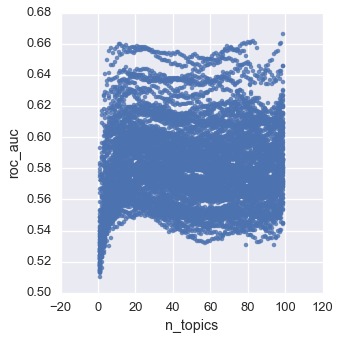

In [36]:
sns.lmplot('n_topics', 'roc_auc', performance_by_topics, lowess=True)

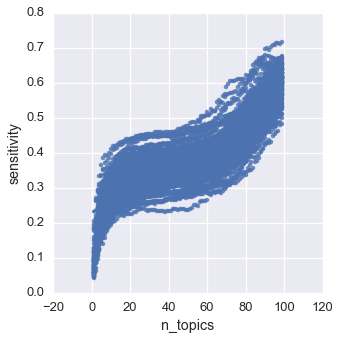

In [37]:
sns.lmplot('n_topics', 'sensitivity', performance_by_topics, lowess=True)

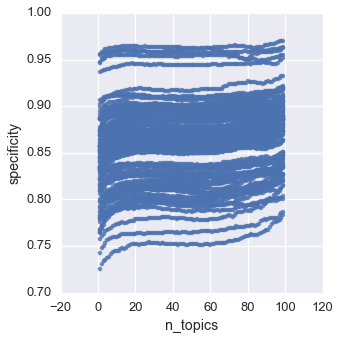

In [38]:
sns.lmplot('n_topics', 'specificity', performance_by_topics, lowess=True)

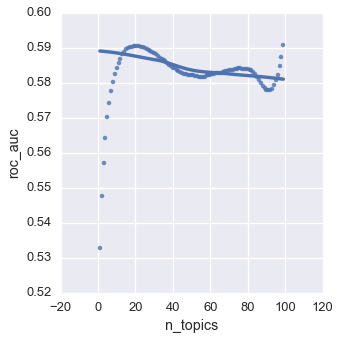

In [39]:
sns.lmplot('n_topics', 'roc_auc', performance_by_topics.groupby('n_topics').mean().reset_index(), lowess=True)

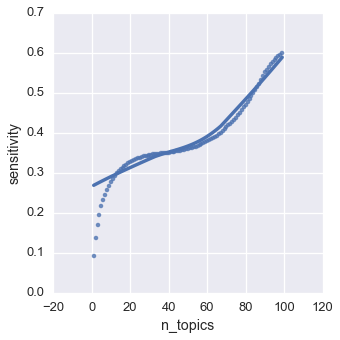

In [40]:
sns.lmplot('n_topics', 'sensitivity', performance_by_topics.groupby('n_topics').mean().reset_index(), lowess=True)

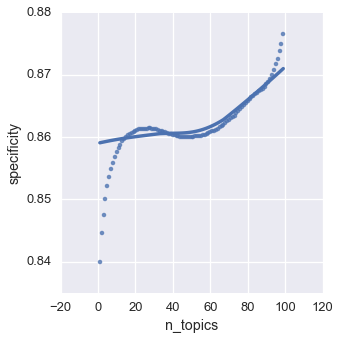

In [41]:
sns.lmplot('n_topics', 'specificity', performance_by_topics.groupby('n_topics').mean().reset_index(), lowess=True)

### Sensitivity curves across n_topics and n_regions

In [42]:
all_k_scores = []
for f in glob.glob('../results/classification/neurosynth_mc_*_GNB_t0.05_all_topics_*/classifier_nd.pkl'):
    clf = OnevsallClassifier.load(f)
    for i, (predictions) in enumerate(clf.predictions):
        report = mean_roc_report(predictions)
        report['region'] = i
        report['n_regions'] = clf.feature_importances.shape[0]
        report['n_topics'] = clf.feature_importances.shape[1]
        all_k_scores.append(report)

In [43]:
all_k_scores = pd.DataFrame(all_k_scores)

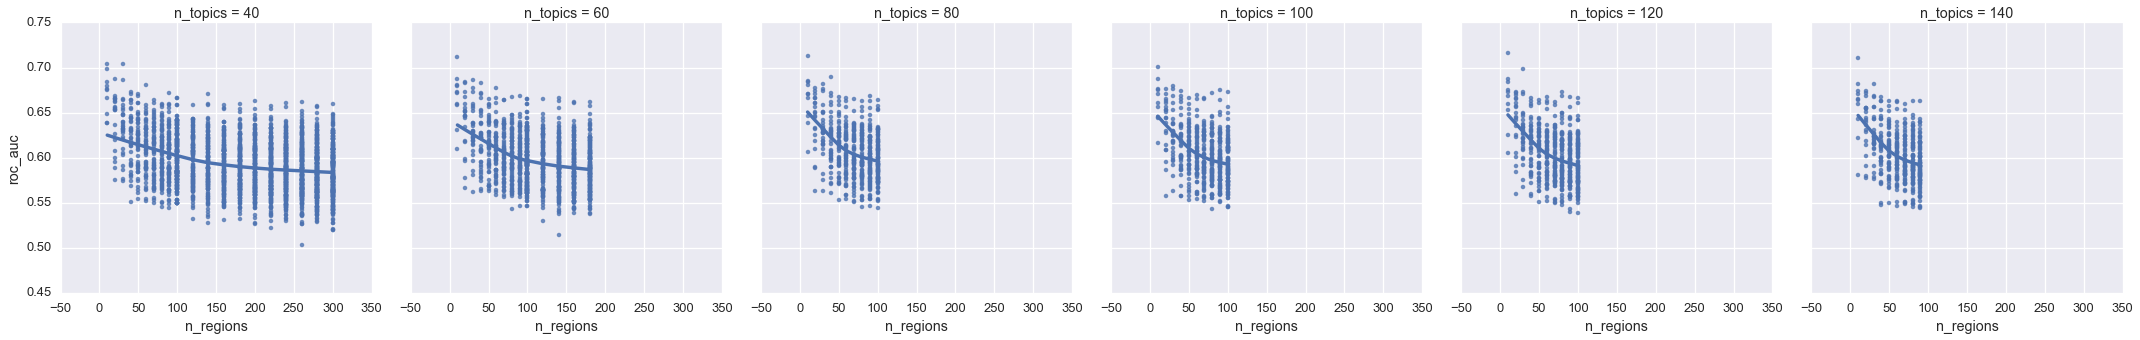

In [44]:
sns.lmplot('n_regions', 'roc_auc', all_k_scores, col='n_topics', lowess=True)

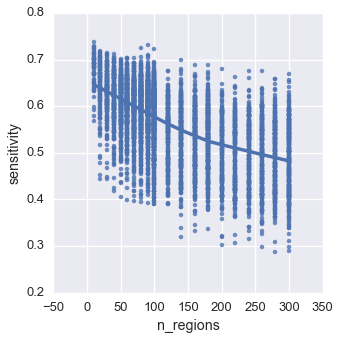

In [45]:
sns.lmplot('n_regions', 'sensitivity', all_k_scores, lowess=True)

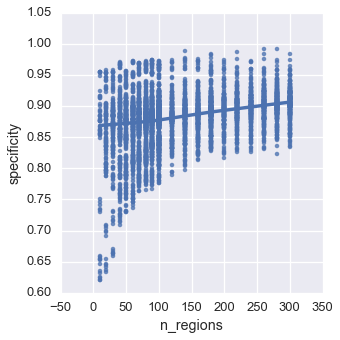

In [46]:
sns.lmplot('n_regions', 'specificity', all_k_scores, lowess=True)

Rerun with more regions

## Predict topics with activation- more like reverse inference?

In [47]:
## Need average within topfics function
## For each topic determine two sets of studies - associated with and not associated with (threshold - low threshold)
## Determine activation level in regon for each of these studies and use as prediction

In [48]:
from neurosynth.analysis.reduce import average_within_regions

In [49]:
topic_activation = average_within_regions(
                dataset, clf.mask_img)

In [50]:
topic_loadings = dataset.feature_table.data[['2_pain_ocd_painful']]

In [51]:
y = (topic_loadings.values > 0.001).astype('int').squeeze()

In [63]:
## All regions
X = topic_activation.T
output = classify.classify(
        X, y, classifier=clf.classifier, cross_val='4-Fold', scoring = roc_auc_score)
mean_roc_report(output['predictions'])

{'roc_auc': 0.5997424159121939,
 'sensitivity': 0.32836436628737498,
 'specificity': 0.94455728698987207}

In [53]:
np.hstack(zip(*output['predictions'])[1]).mean()

0.14299491495704014

In [54]:
## DACC
X = topic_activation[dacc, :].reshape(1, -1).T
output = classify.classify(
        X, y, classifier=clf.classifier, cross_val='4-Fold', scoring = roc_auc_score)
mean_roc_report(output['predictions'])

{'roc_auc': 0.50952602977741668,
 'sensitivity': 0.035940347766119901,
 'specificity': 0.93052366688012711}

In [55]:
np.hstack(zip(*output['predictions'])[1]).mean()

0.018236016131860423

In [56]:
## DLPFC
X = topic_activation[mid_dlpfc, :].reshape(1, -1).T
output = classify.classify(
        X, y, classifier=clf.classifier, cross_val='4-Fold', scoring = roc_auc_score)
mean_roc_report(output['predictions'])

{'roc_auc': 0.5, 'sensitivity': 0.0, 'specificity': 0.92924780394183215}

In [60]:
np.hstack(zip(*output['predictions'])[1]).mean()

0.0

Classifier says inactive most of the time - which is actually true but also misses many true positives. Useful regions (e.g. dACC and pain), increase this substantially but still result in relatively low performance - because regions are likely activated by many difference scenarios. 

- Which regions have the highest sensitivity? Which specific regions:topic relations have the highest sensitivity?
- Important to look at overall performance with all regions (it's likely limited by number of regions)


## By granularity of parcellation, compared to craddock

In this analysis, for every topic I find the most predictive region (by log odds ratio) and compute specificity/sensitivity/roc_auc. For various granularities of neurosynth maps

In [274]:
from joblib import Memory, Parallel, delayed
memory = Memory(cachedir='../cache/', verbose=0)

In [293]:
def parallel_best_region(f, X, topic):
    topic_loadings = dataset.feature_table.data[[topic]]
    y = (topic_loadings.values > 0.001).astype('int').squeeze()

    try:
        output = classify.classify(
            X, y, classifier=clf.classifier, cross_val='4-Fold', scoring = roc_auc_score)
        
        full_report = mean_roc_report(output['predictions'])
        full_report['n_regions'] = X.shape[1]
        full_report['topic'] = topic
        
        odr = np.log(output['clf'].clf.theta_[1] / output['clf'].clf.theta_[0])
        topic_max = np.where(odr == odr.max())[0]

        X_best = X[:, topic_max]
        output = classify.classify(
            X_best, y, classifier=clf.classifier, cross_val='4-Fold', scoring = roc_auc_score)
        report = mean_roc_report(output['predictions'])
        report['n_regions'] = X.shape[1]
        report['topic'] = topic

        return full_report, report
    except ValueError:
        return None, None

In [272]:
best_region_topic = []
all_regions_topic = []
ns_atlases = glob.glob('../results/clustering/matched/craddock/cluster_labe*')
original_atlases = glob.glob('../masks/craddock/scorr_05_2level/*.nii.gz')
all_topics = dataset.get_feature_names()

ns_regions = [int(reg.split('k')[2].split('.')[0]) for reg in ns_atlases]
original_regions = [np.round(int(reg.split('/')[4].split('.')[0]), -1) for reg in original_atlases]
common_regions = list(set(ns_regions).intersection(original_regions))

In [294]:
predict_topics = []
pb = tools.ProgressBar(len(common_regions) * 2, start=True)

for i, f in enumerate(ns_atlases):
    if ns_regions[i] in common_regions:
        X = average_within_regions(dataset, f).T
        for full_report, report in Parallel(n_jobs=7)(delayed(parallel_best_region)(f, X, topic) for topic in all_topics):
            if report is not None:
                report['atlas'] = 'neurosynth'
                report['regions'] = 'best'
                full_report['atlas'] = 'neurosynth'
                full_report['regions'] = 'all'
                predict_topics.append(report)
                predict_topics.append(full_report)
        pb.next()
                
for i, f in enumerate(original_atlases):
    if original_regions[i] in common_regions:
        X = average_within_regions(dataset, f).T
        for full_report, report in Parallel(n_jobs=7)(delayed(parallel_best_region)(f, X, topic) for topic in all_topics):
            if report is not None:
                report['atlas'] = 'craddock'
                report['regions'] = 'best'
                full_report['atlas'] = 'craddock'
                full_report['regions'] = 'all'
                predict_topics.append(report)
                predict_topics.append(full_report)
        pb.next()

TypeError: can't pickle function objects

In [ ]:
predict_topics = pd.DataFrame(predict_topics)
predict_topics = predict_topics.sort_values('regions')

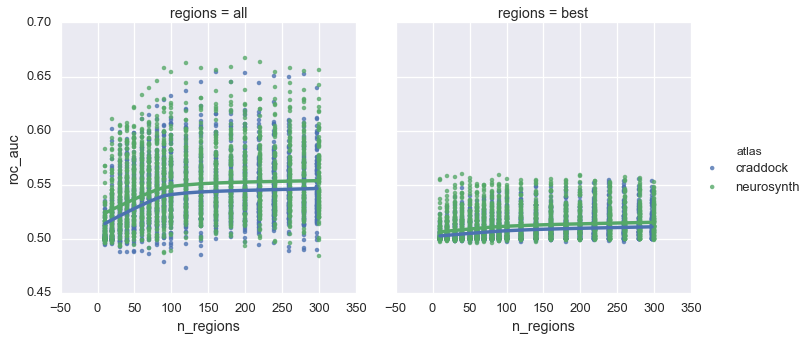

In [251]:
sns.lmplot('n_regions', 'roc_auc', predict_topics,  hue='atlas', col='regions', lowess=True)

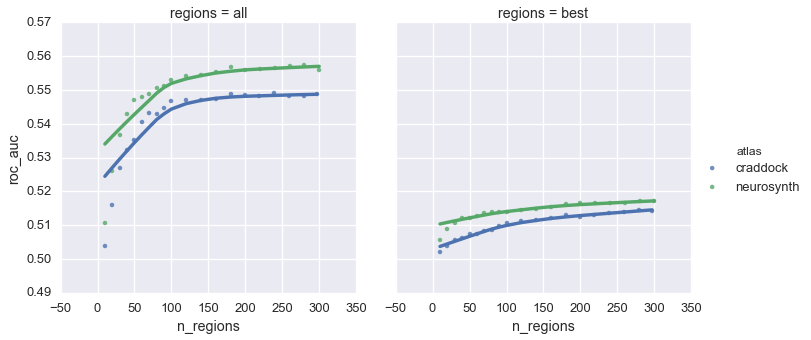

In [252]:
sns.lmplot('n_regions', 'roc_auc', predict_topics_mean,  hue='atlas', col='regions', lowess=True)

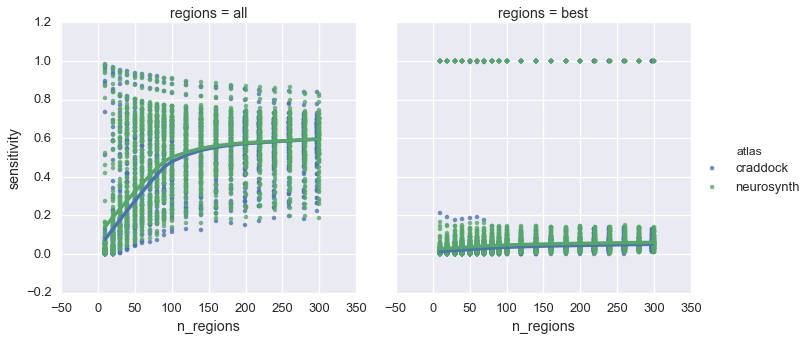

In [253]:
sns.lmplot('n_regions', 'sensitivity', predict_topics,  hue='atlas', col='regions', lowess=True)

What are these high sensitivity w/ 1 region topics?
Probably better to re-do this with only cognitive topics

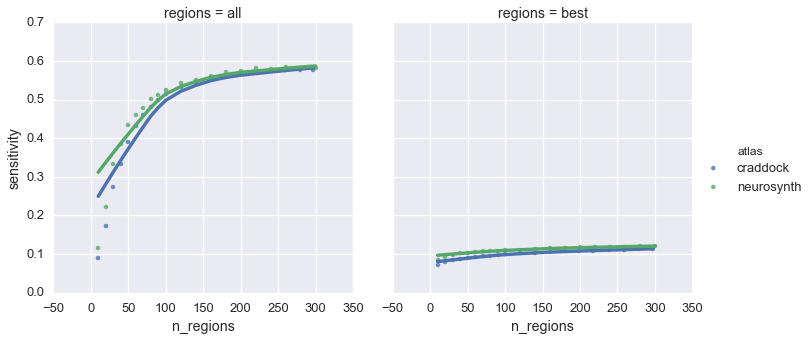

In [254]:
sns.lmplot('n_regions', 'sensitivity', predict_topics_mean,  hue='atlas', col='regions', lowess=True)

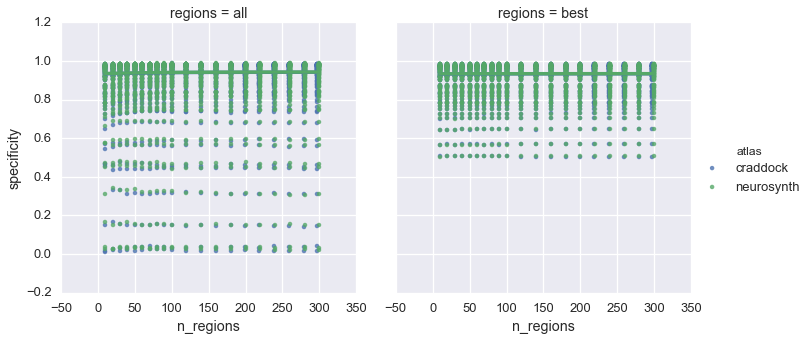

In [255]:
sns.lmplot('n_regions', 'specificity', predict_topics,  hue='atlas', col='regions', lowess=True)

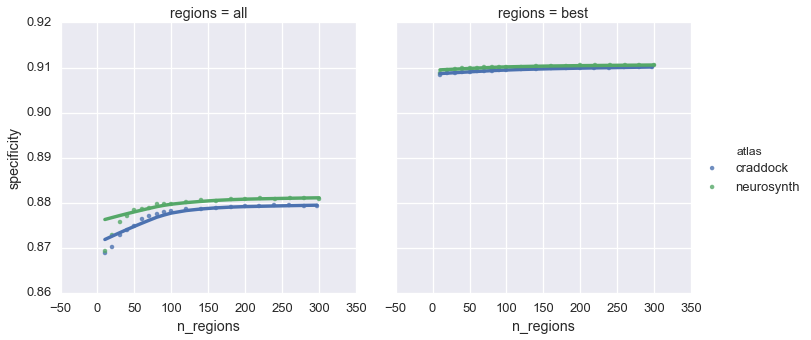

In [256]:
sns.lmplot('n_regions', 'specificity', predict_topics_mean,  hue='atlas', col='regions', lowess=True)

## Compare to AAL atlas